In [1]:
import pandas as pd

mail_df = pd.read_csv("../data/emails.csv", sep=";", nrows=10000)
#mail_df = pd.read_csv("../data/emails.csv", sep=";")
mail_df = mail_df.drop(["cc"], axis=1)
mail_df = mail_df.rename(columns={"from": "from_"})
mail_df.drop(mail_df.query("from_ == '' | to == '' | subject == '' | date == '' | body == ''").index, inplace=True)
mail_df.head()


,from_,to,subject,date,body
0,monique.sanchez@enron.com,"sanchez@enron.com, ksanchez@houstonisd.org",RE: Response requested,"Wed, 2 May 2001 16:28:00 -0700 (PDT)",just Associate.....at Enron Wholesale Services...
1,monique.sanchez@enron.com,scottatlas@yahoo.com,RE: Reminder,"Wed, 10 Oct 2001 14:51:35 -0700 (PDT)",I would wear nice slacks and a nice shirt...ma...
2,monique.sanchez@enron.com,rosie.m.gonzalez@chase.com,RE: testing,"Wed, 23 May 2001 12:40:57 -0700 (PDT)",I'm glad you remembered my email. Glad to see...
3,monique.sanchez@enron.com,joseph.f.reid@accenture.com,Re: you can't hide...,"Mon, 14 May 2001 14:53:00 -0700 (PDT)","Hey there,\n\nDid you call me at the Derby? I..."
4,monique.sanchez@enron.com,moshuffle@hotmail.com,FW: Tuesday's P/L,"Wed, 30 May 2001 06:49:31 -0700 (PDT)","\n\n -----Original Message-----\nFrom: \tBike,..."


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np


my_stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient', 'sent', 'enron', 'cc', 'subject',\
                                         'forwarded', 'corp', 'said', 'attached', 'ect',\
                                         'recipient', 'email', 'original', 'doc', 'pm', 'mail', 'message', 'new'\
                                         'enronxgate', 'na', 'year'])

# cv = TfidfVectorizer(stop_words=my_stopwords, max_df=0.50, min_df=2)
cv = CountVectorizer(analyzer='word', stop_words=my_stopwords, max_features=2000)


X = cv.fit_transform(mail_df.body)

X_dense = X.todense()
#coords = PCA(n_components=2).fit_transform(X_dense)
#plt.scatter(coords[:, 0], coords[:, 1], c='m')
#plt.show()

In [6]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = cv.get_feature_names_out()
print(top_feats_in_doc(X, features, 1, 10))


   features  score
0     yahoo      8
1     scott      5
2  intended      4
3   sanchez      3
4      nice      3
5    friday      3
6   monique      3
7  reminder      3
8        09      2
9       use      2


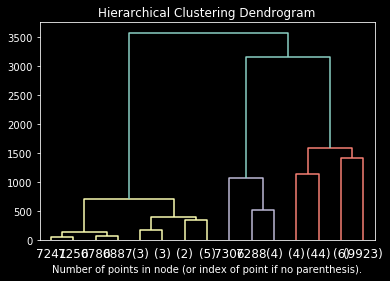

In [4]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

#ag = AgglomerativeClustering(n_clusters=100).fit(X.toarray())
ag = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X.toarray())

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(ag, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()